<a href="https://colab.research.google.com/github/YasserJxxxx/Specter_IA_Cat_Dog/blob/main/ClasificacionPerrosvsGatos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iniciando configuración...
Librerías instaladas. Montando Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✅ Datos pre-procesados encontrados en Drive. Cargando...
Datos cargados. Forma de X: (2000, 4096)

Conjunto de Entrenamiento: 1600 | Prueba: 400
✅ Modelo de Regresión Logística cargado desde Drive.

   RESULTADOS DE EVALUACIÓN DEL MODELO CON REGRESIÓN LOGÍSTICA

### 3.1. Reporte de Clasificación
              precision    recall  f1-score   support

        Gato       0.52      0.54      0.53       200
       Perro       0.52      0.51      0.51       200

    accuracy                           0.52       400
   macro avg       0.52      0.52      0.52       400
weighted avg       0.52      0.52      0.52       400


### 3.2. Explicación de Métricas Clave

**1. Precisión General (Accuracy):** 0.5225 (52.25%)
  - **Definición:** Proporción de predicciones totales que fueron correctas (A

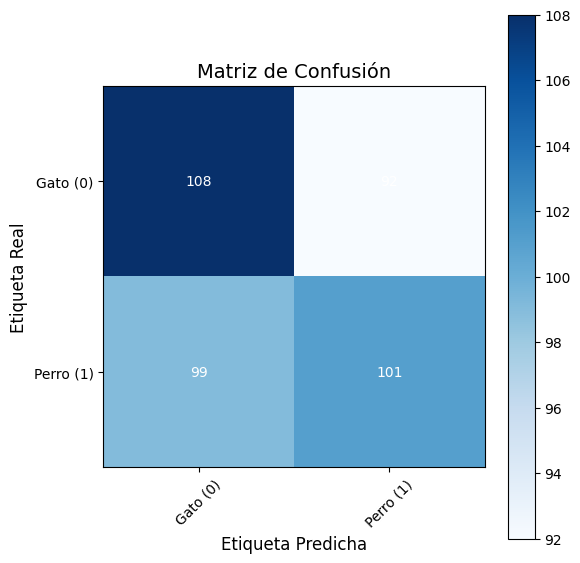


   CLASIFICADOR INTERACTIVO (PRUEBA CON IMAGEN PROPIA)
Por favor, sube una imagen de un Perro o un Gato para clasificarla:


Saving gatocomuneuropeo-97.webp to gatocomuneuropeo-97 (1).webp


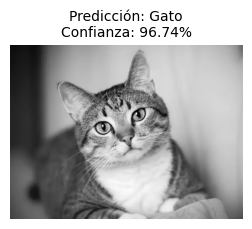


Resultado para gatocomuneuropeo-97 (1).webp: CLASIFICADO como **Gato** con 96.74% de certeza.


In [6]:
# ==============================================================================
# 1. SETUP, INSTALACIÓN, IMPORTACIONES Y PERSISTENCIA DE DATOS
# ==============================================================================
print("Iniciando configuración...")
# Instalar librerías silenciosamente
!pip install kagglehub opencv-python joblib -q
print("Librerías instaladas. Montando Google Drive...")

import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from google.colab import drive, files
import kagglehub
import joblib
import pandas as pd # Aseguramos la importación de pandas para la tabla

# --- 1.1. Montar Google Drive para persistencia ---
drive.mount('/content/drive')
DRIVE_PATH = '/content/drive/MyDrive/Colab_Data_LogReg_DogsCats/'
PROCESSED_DATA_FILE = os.path.join(DRIVE_PATH, 'dogs_cats_logistic_data.npz')
MODEL_FILE = os.path.join(DRIVE_PATH, 'logistic_regression_model.pkl')

if not os.path.exists(DRIVE_PATH):
    os.makedirs(DRIVE_PATH)
    print(f"Carpeta de Drive creada: {DRIVE_PATH}")

# Inicializar variables
X = np.array([])
y = np.array([])
IMG_SIZE = (64, 64)

# --- 1.2. Lógica de Carga/Descarga/Pre-procesamiento ---
try:
    if os.path.exists(PROCESSED_DATA_FILE):
        print("\n✅ Datos pre-procesados encontrados en Drive. Cargando...")
        data = np.load(PROCESSED_DATA_FILE, allow_pickle=True)
        X = data['X']
        y = data['y']
        print(f"Datos cargados. Forma de X: {X.shape}")

    else:
        raise FileNotFoundError

except FileNotFoundError:
    print("\n❌ Datos pre-procesados no encontrados. Iniciando descarga y pre-procesamiento...")

    # Descarga de Kaggle
    try:
        path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")
        DATA_DIR = path
    except Exception as e:
        print(f"Error al descargar: {e}")
        raise SystemExit("No se puede continuar sin el dataset.")

    # --- Pre-procesamiento de Datos ---
    MAX_SAMPLES_PER_CLASS = 1000
    X_list = []
    y_list = []

    def process_images(folder_path, label):
        count = 0
        if not os.path.exists(folder_path): return

        for filename in os.listdir(folder_path):
            if count >= MAX_SAMPLES_PER_CLASS: break
            if not filename.lower().endswith(('.png', '.jpg', '.jpeg')): continue

            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is not None:
                try:
                    img_resized = cv2.resize(img, IMG_SIZE)
                    img_flattened = img_resized.flatten()
                    img_normalized = img_flattened / 255.0

                    X_list.append(img_normalized)
                    y_list.append(label)
                    count += 1
                except Exception:
                    continue
        print(f"-> Cargadas {count} imágenes para la etiqueta {label} desde {os.path.basename(folder_path)}.")

    # --- AJUSTE DE RUTA DE CARPETAS ---
    BASE_DIR = os.path.join(DATA_DIR, 'Dog_Cat_Training_Set')
    CAT_DIR = os.path.join(BASE_DIR, 'Cat')
    DOG_DIR = os.path.join(BASE_DIR, 'Dog')

    if os.path.exists(CAT_DIR) and os.path.exists(DOG_DIR):
        process_images(CAT_DIR, 0)
        process_images(DOG_DIR, 1)
    else:
        print(f"❌ ¡ERROR DE RUTA! No se encontraron las carpetas en {BASE_DIR}.")
        raise SystemExit("El script no puede continuar sin datos.")

    X = np.array(X_list)
    y = np.array(y_list)

    if X.shape[0] == 0:
        raise SystemExit("❌ No se pudo cargar ninguna imagen. Verifica las rutas o archivos.")

    # --- GUARDAR DATOS PRE-PROCESADOS EN DRIVE ---
    np.savez_compressed(PROCESSED_DATA_FILE, X=X, y=y)
    print(f"\n💾 Datos pre-procesados guardados en Drive: {PROCESSED_DATA_FILE}")


# ==============================================================================
# 2. ENTRENAMIENTO DEL MODELO Y PERSISTENCIA
# ==============================================================================

# División de datos: 80% Entrenamiento, 20% Prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nConjunto de Entrenamiento: {X_train.shape[0]} | Prueba: {X_test.shape[0]}")

try:
    # Intenta cargar el modelo si ya existe
    if os.path.exists(MODEL_FILE):
        log_reg_model = joblib.load(MODEL_FILE)
        print("✅ Modelo de Regresión Logística cargado desde Drive.")
    else:
        raise FileNotFoundError

except FileNotFoundError:
    # Si no existe, entrenar uno nuevo
    print("❌ Modelo no encontrado. Iniciando entrenamiento...")
    log_reg_model = LogisticRegression(solver='lbfgs', max_iter=2000, random_state=42)
    log_reg_model.fit(X_train, y_train)
    print("¡Entrenamiento completado!")

    # Guardar el modelo entrenado
    joblib.dump(log_reg_model, MODEL_FILE)
    print(f"💾 Modelo guardado en Drive: {MODEL_FILE}")

# ==============================================================================
# 3. PREDICCIÓN Y EVALUACIÓN DE MÉTRICAS (CON EXPLICACIÓN)
# ==============================================================================

y_pred = log_reg_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report_dict = classification_report(y_test, y_pred, target_names=['Gato', 'Perro'], output_dict=True)

print(f"\n{'='*60}")
print("   RESULTADOS DE EVALUACIÓN DEL MODELO CON REGRESIÓN LOGÍSTICA")
print(f"{'='*60}")

# --- 3.1. Reporte de Clasificación (Precision, Recall, F1-Score) ---
print("\n### 3.1. Reporte de Clasificación")
print(classification_report(y_test, y_pred, target_names=['Gato', 'Perro']))


# --- 3.2. Explicación de las Métricas ---

print("\n### 3.2. Explicación de Métricas Clave")

# 1. Precisión General (Accuracy)
accuracy = class_report_dict['accuracy']
print(f"\n**1. Precisión General (Accuracy):** {accuracy:.4f} ({(accuracy*100):.2f}%)")
print("  - **Definición:** Proporción de predicciones totales que fueron correctas (Aciertos / Total de muestras).")

# 2. Matriz de Confusión
print("\n**2. Matriz de Confusión:**")

# Formato la Matriz de Confusión con una tabla para mejor visualización
df_cm = pd.DataFrame(conf_matrix, index=['Real Gato (0)', 'Real Perro (1)'], columns=['Predicho Gato (0)', 'Predicho Perro (1)'])

print(df_cm.to_markdown(numalign="left", stralign="left"))
print("  - **TN (Gato/Gato):** Verdaderos Negativos (Gatos clasificados correctamente).")
print("  - **FP (Perro/Gato):** Falsos Positivos (Gatos clasificados incorrectamente como Perros).")
print("  - **FN (Gato/Perro):** Falsos Negativos (Perros clasificados incorrectamente como Gatos).")
print("  - **TP (Perro/Perro):** Verdaderos Positivos (Perros clasificados correctamente).")


# 3. Precisión (Precision)
print(f"\n**3. Precisión (Precision):**")
print(f"  - **Gato (0):** {class_report_dict['Gato']['precision']:.4f}")
print(f"  - **Perro (1):** {class_report_dict['Perro']['precision']:.4f}")
print("  - **Definición:** De todas las predicciones para una clase, ¿cuántas fueron realmente correctas? Mide la **fiabilidad** del modelo en sus predicciones positivas.")

# 4. Exhaustividad (Recall)
print(f"\n**4. Exhaustividad (Recall):**")
print(f"  - **Gato (0):** {class_report_dict['Gato']['recall']:.4f}")
print(f"  - **Perro (1):** {class_report_dict['Perro']['recall']:.4f}")
print("  - **Definición:** De todos los casos reales de una clase, ¿cuántos fueron identificados correctamente? Mide la capacidad del modelo para **encontrar** todas las instancias positivas.")

# 5. Puntuación F1 (F1-Score)
print(f"\n**5. Puntuación F1 (F1-Score):**")
print(f"  - **Gato (0):** {class_report_dict['Gato']['f1-score']:.4f}")
print(f"  - **Perro (1):** {class_report_dict['Perro']['f1-score']:.4f}")
print("  - **Definición:** Media armónica de Precisión y Exhaustividad. Útil para obtener un **equilibrio** entre ambas métricas.")

# --- 3.3. Visualización de la Matriz de Confusión ---
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión', fontsize=14)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Gato (0)', 'Perro (1)'], rotation=45)
plt.yticks(tick_marks, ['Gato (0)', 'Perro (1)'])
plt.ylabel('Etiqueta Real', fontsize=12)
plt.xlabel('Etiqueta Predicha', fontsize=12)

# Añadir etiquetas de texto
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

# ==============================================================================
# 4. FUNCIÓN DE CLASIFICACIÓN INTERACTIVA (INFERENCIA)
# ==============================================================================

def classify_uploaded_image(model, img_size):
    """Permite al usuario subir una imagen y la clasifica."""
    print(f"\n{'='*60}")
    print("   CLASIFICADOR INTERACTIVO (PRUEBA CON IMAGEN PROPIA)")
    print(f"{'='*60}")
    print("Por favor, sube una imagen de un Perro o un Gato para clasificarla:")

    # Abrir el diálogo de subida de archivos
    uploaded = files.upload()

    if not uploaded:
        print("No se subió ninguna imagen.")
        return

    for filename in uploaded.keys():
        # Leer la imagen subida
        img_np = np.frombuffer(uploaded[filename], np.uint8)
        img = cv2.imdecode(img_np, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Error: No se pudo leer la imagen {filename}.")
            return

        # 1. Pre-procesamiento (Debe ser idéntico al entrenamiento)
        img_resized = cv2.resize(img, img_size)
        img_flattened = img_resized.flatten()
        img_normalized = img_flattened / 255.0

        # Redimensionar para el modelo (1 muestra, 4096 características)
        X_new = img_normalized.reshape(1, -1)

        # 2. Predicción
        prediction = model.predict(X_new)[0]
        # Probabilidad de ser la clase 1 (Perro)
        prediction_proba = model.predict_proba(X_new)[0][1]

        # 3. Resultado
        label = "Perro" if prediction == 1 else "Gato"
        confidence = prediction_proba if prediction == 1 else 1 - prediction_proba

        # 4. Mostrar la imagen y el resultado
        plt.figure(figsize=(3, 3))
        plt.imshow(img, cmap='gray')
        plt.title(f"Predicción: {label}\nConfianza: {confidence*100:.2f}%", fontsize=10)
        plt.axis('off')
        plt.show()

        print(f"\nResultado para {filename}: CLASIFICADO como **{label}** con {confidence*100:.2f}% de certeza.")

# Llamar a la función de clasificación
classify_uploaded_image(log_reg_model, IMG_SIZE)